In [ ]:
import numpy as np
import pandas as pd
import wordcloud
import seaborn as sns
import matplotlib.pyplot as plt


from keras import backend as K

from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.models import Sequential
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding,concatenate, Bidirectional
from keras.layers import Dropout, Input, LeakyReLU, Conv1D, GlobalMaxPooling1D,InputLayer, ReLU, LSTM


#Utils
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils import vis_utils
from sklearn.manifold import TSNE

#!pip3 install keras_metrics
import tensorflow as tf
from tensorflow.python.keras.metrics import Metric
from tensorflow.keras.optimizers import Adam

import io
from google.colab import files


In [ ]:
from google.colab import drive
# "drive/MyDrive/Glove/Visuals/
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#metrics
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#Classifiers 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Time and counters
from time import perf_counter

#grid search of params
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

# NLP lib
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk import flatten , PorterStemmer, WordNetLemmatizer, FreqDist
from collections import Counter

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

#Mark Down print
from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

# File optimization
import h5py

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# import sys
# sys.path.append('drive/MyDrive/SPAM classification deep learning/')
# from utils import *
"""
printmd, get_confusion_matrix_heatmap, ROC_AUC, Word_Embeddings_visualise_TSNE, 
read_glove_vecs, X_to_index, sentences_to_indices, get_Metrics, 
pretrained_embedding_layer,  ANN_with_glove, RNN_with_glove, CNN_with_glove
ANN_with_glove_architecture_2
""" 


'\nprintmd, get_confusion_matrix_heatmap, ROC_AUC, Word_Embeddings_visualise_TSNE, \nread_glove_vecs, X_to_index, sentences_to_indices, get_Metrics, \npretrained_embedding_layer,  ANN_with_glove, RNN_with_glove, CNN_with_glove\nANN_with_glove_architecture_2\n'

In [ ]:
import sys
sys.path.append('drive/MyDrive/Glove/')
!ls
from utils import *
"""
printmd, get_confusion_matrix_heatmap, ROC_AUC, Word_Embeddings_visualise_TSNE, 
read_glove_vecs, X_to_index, sentences_to_indices, get_Metrics, 
pretrained_embedding_layer,  ANN_with_glove, RNN_with_glove, CNN_with_glove
ANN_with_glove_architecture_2
""" 


drive  sample_data


'\nprintmd, get_confusion_matrix_heatmap, ROC_AUC, Word_Embeddings_visualise_TSNE, \nread_glove_vecs, X_to_index, sentences_to_indices, get_Metrics, \npretrained_embedding_layer,  ANN_with_glove, RNN_with_glove, CNN_with_glove\nANN_with_glove_architecture_2\n'

In [ ]:
#Paths

heatmaps = "drive/MyDrive/Glove/heatmaps/"
Visuals = "drive/MyDrive/Glove/Visuals/"
Glove   = "drive/MyDrive/Glove/"
Model   = "drive/MyDrive/Glove/Model/"
print(f'{Glove}Augmented_emails.csv')

drive/MyDrive/Glove/Augmented_emails.csv


# Data set Cleaning

In [ ]:
#Test Train Split of Data
# load data

# data = pd.read_csv('drive/MyDrive/SPAM classification deep learning/Dataset/Augmented_emails.csv')
data = pd.read_csv(f'{Glove}Augmented_emails.csv')
#Label
data['spam'] = [1 if x == 1.0 else 0 for x in data['spam']]

#remove duplicated data
print(f"duplicated entries {data.duplicated().sum()}\n")
data = data.drop_duplicates()
print(f"duplicated entries {data.duplicated().sum()}\n")

#remove Null values
print("Number of null features in the dataset :")
print(f"{data.isnull().sum()}\n")

data.dropna(subset=["spam"], inplace=True)

print("Number of null features in the dataset :")
print(f"{data.isnull().sum()}")
print()

print(f"shape of the dataset : {data.shape}, Number of rows and columns : {data.shape[0]} , {data.shape[1]}\n")

# Convert data to H5py file 
data.to_hdf(f'{Glove}data_1.h5', 'data', mode='w',format='table',data_columns=True)

data = pd.read_hdf(f'{Glove}data_1.h5', 'data')
data = pd.DataFrame(data)
#Make a copy of the data set.
data_ANN_RNN_CNN = data.copy()

data.head(10)

duplicated entries 0

duplicated entries 0

Number of null features in the dataset :
X       2
spam    0
dtype: int64

Number of null features in the dataset :
X       2
spam    0
dtype: int64

shape of the dataset : (5495, 2), Number of rows and columns : 5495 , 2



,X,spam
0,naturally irresistible corporate identity real...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable home made easy wanting show homeo...,1
3,color printing special request additional info...,1
4,money software software compatibility great gr...,1
5,great nnews hello welcome medzonline groundsel...,1
6,play motion homeland security investment terro...,1
7,save money getting thing tried cialls even ima...,1
8,undeliverable home based business grownup mess...,1
9,save money getting thing tried cialls even ima...,1


# **Loading pretrained word embeddings (GLOVE)** 

In [ ]:
"""
Data Preprocessing to be used with glove

Tasks : Convert input data/Train data to glove word index
"""
from nltk.tokenize import word_tokenize
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(f'{Glove}glove.6B.100d.txt')
max_length = 2400
Embed_size = 100

print(len(word_to_index))
print(len(index_to_word))

400001
400001


# **Data set Pre-processing**

In [ ]:
data_ANN_RNN_CNN = data_ANN_RNN_CNN.filter(['X','spam'], axis=1)
data_ANN_RNN_CNN_index = data_ANN_RNN_CNN["X"].copy()
data_ANN_RNN_CNN_index = data_ANN_RNN_CNN_index.astype(str)
# data_ANN_RNN_CNN_index = data_ANN_RNN_CNN_index.apply(lambda x: X_to_index(x, word_to_index, max_length))
X = sentences_to_indices(data_ANN_RNN_CNN_index, word_to_index, max_length)


#Label
Y = data_ANN_RNN_CNN['spam'].copy()
Y = [1 if x == 1.0 else 0.0 for x in Y]
Y = np.asarray(Y).astype('float32') 

# X.shape
print(X.shape)
print(type(X))

(5495, 2400)
<class 'numpy.ndarray'>


In [ ]:
print(type(X))

<class 'numpy.ndarray'>


In [ ]:
print(X.dtype)
X = X.astype("int32")
print(X.dtype)

float64
int32


In [ ]:
for i in range(10):
  txt = data_ANN_RNN_CNN["X"][i]
  idx = X[i]
  print(f"{i}th training sample text : \n{txt}\n")
  print(f"{i}th training sample indexed : \n{idx}\n")

0th training sample text : 
naturally irresistible corporate identity really hard recollect company market full suqgestions information isoverwhelminq good catchy logo stylish statlonery outstanding website make task much easier promise havinq ordered iogo company automaticaily become world ieader isguite ciear without good product effective business organization practicable hotat nowadays market promise marketing effort become much effective list clear benefit creativeness hand made original logo specially done reflect distinctive company image convenience logo stationery provided format easy content management system letsyou change website content even structure promptness logo draft within three business day affordability marketing break make gap budget satisfaction guaranteed provide unlimited amount change extra fee surethat love result collaboration look portfolio interested

0th training sample indexed : 
[257316 192882 109423 ...      0      0      0]

1th training sample text 

# **Dataset Test Train Split (80 20 split)**

In [ ]:
# type(Y)
# #Splitting the data - 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X , Y, test_size = 0.2, random_state = 99)
print(f"Training split input: {X_train.shape}")
print(f"Testing split input : {X_test.shape}")
print(f"Training split class: {y_train.shape}")
print(f"Testing split class : {y_test.shape}\n")

print("dtypes :")
print(f"Train : {X_train.dtype}")
print(f"Test : {X_test.dtype}")
print(f"Train label : {y_train.dtype}")
print(f"Test label : {y_test.dtype}\n")

print("Types :")
print(f"Train : {type(X_train.dtype)}")
print(f"Test : {type(X_test.dtype)}")
print(f"Train label : {type(y_train.dtype)}")
print(f"Test label : {type(y_test.dtype)}\n")

Training split input: (4396, 2400)
Testing split input : (1099, 2400)
Training split class: (4396,)
Testing split class : (1099,)

dtypes :
Train : int32
Test : int32
Train label : float32
Test label : float32

Types :
Train : <class 'numpy.dtype'>
Test : <class 'numpy.dtype'>
Train label : <class 'numpy.dtype'>
Test label : <class 'numpy.dtype'>



In [ ]:
for i in range(3):
  print(X_train[i])

[372267 356798 107050 ...      0      0      0]
[164329 249943 379260 ...      0      0      0]
[191533 270807 118310 ...      0      0      0]


## **GPU Support**

In [ ]:
"""
GPU support
"""
#' ' means CPU whereas '/device:G:0' means GPU

tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=31b59192128197951367c4635d5934517c2a512623051ab49b63b1bdf25b2cfb
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 25.5 GB  | Proc size: 1.8 GB
GPU RAM Free: 15935MB | Used: 345MB | Util   2% | Total 16280MB


In [ ]:
# kill the machine
# !kill -9 -1


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.4903434450000077
GPU (s):
0.03164271600007851
GPU speedup over CPU: 47x


# **ANN with Glove**

In [ ]:
"""
ANN with glove
"""
ann_glove = ANN_with_glove((max_length,), word_to_vec_map, word_to_index)
# ann_glove = ANN_with_glove_architecture_2((max_length,), word_to_vec_map, word_to_index)
ann_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2400)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2400, 100)         40000200  
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0     

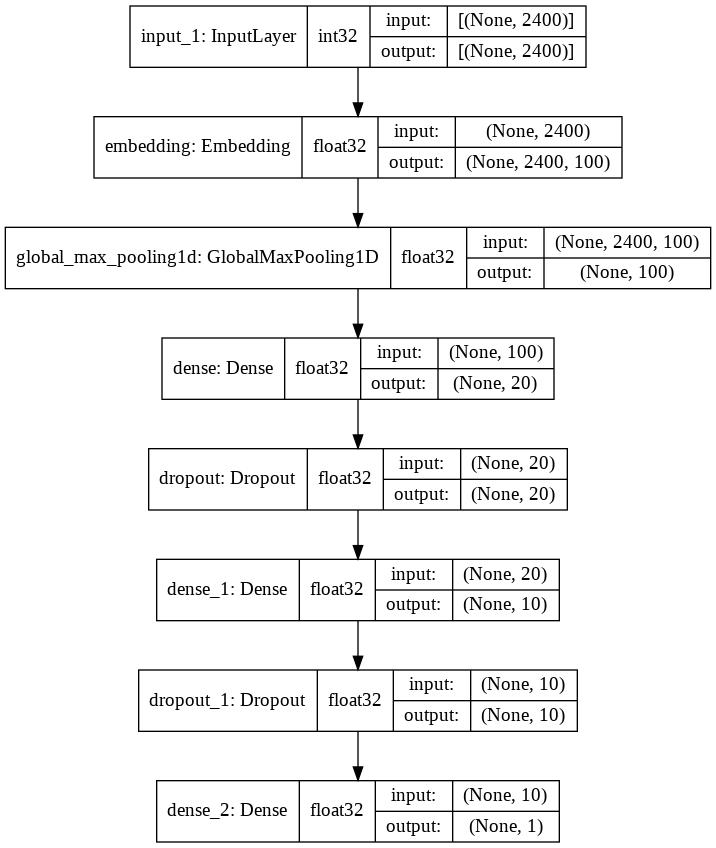

In [ ]:
# display model layers
print(ann_glove.summary())
plot_model(
    ann_glove,
    to_file=f"{Visuals}ann_glove_1.jpeg",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [ ]:
#Information about dtypes of layers of the model
[print(i.shape, i.dtype) for i in ann_glove.inputs]
print("\n\n")
[print(o.shape, o.dtype) for o in ann_glove.outputs]
print("\n\n")
[print(l.name, l.input_shape, l.dtype) for l in ann_glove.layers]

(None, 2400) <dtype: 'int32'>



(None, 1) <dtype: 'float32'>



input_1 [(None, 2400)] int32
embedding (None, 2400) float32
global_max_pooling1d (None, 2400, 100) float32
dense (None, 100) float32
dropout (None, 20) float32
dense_1 (None, 20) float32
dropout_1 (None, 10) float32
dense_2 (None, 10) float32


[None, None, None, None, None, None, None, None]

In [ ]:
# with tf.device('/device:GPU:0'):
start = perf_counter()
history = ann_glove.fit(X_train, y_train, epochs = 100, validation_steps = len(X_test), steps_per_epoch= len(X_train), validation_data=(X_test, y_test), verbose=1)
duration_ann_glove_1 = perf_counter() - start
duration_ann_glove_1 = round(duration_ann_glove_1,2)
ann_history = history

Epoch 1/100
4396/4396 [==============================] - 9s 2ms/step - loss: 0.5385 - accuracy: 0.7509 - val_loss: 0.4507 - val_accuracy: 0.7398
Epoch 2/100
4396/4396 [==============================] - 8s 2ms/step - loss: 0.4425 - accuracy: 0.7541 - val_loss: 0.3597 - val_accuracy: 0.7398
Epoch 3/100
4396/4396 [==============================] - 8s 2ms/step - loss: 0.4004 - accuracy: 0.7632 - val_loss: 0.3273 - val_accuracy: 0.8553
Epoch 4/100
4396/4396 [==============================] - 8s 2ms/step - loss: 0.3831 - accuracy: 0.8082 - val_loss: 0.3419 - val_accuracy: 0.8917
Epoch 5/100
4396/4396 [==============================] - 8s 2ms/step - loss: 0.3700 - accuracy: 0.8144 - val_loss: 0.3162 - val_accuracy: 0.8908
Epoch 6/100
4396/4396 [==============================] - 8s 2ms/step - loss: 0.3571 - accuracy: 0.8260 - val_loss: 0.2729 - val_accuracy: 0.9126
Epoch 7/100
4396/4396 [==============================] - 8s 2ms/step - loss: 0.3500 - accuracy: 0.8248 - val_loss: 0.2696 - val_ac

[[725  88]
 [ 20 266]]


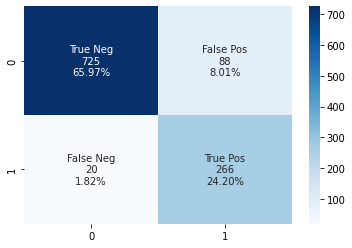

In [ ]:
# Predicting the Test set results
y_pred = ann_glove.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred_ann_glove = np.array(y_pred)

#confusion matrix
get_confusion_matrix_heatmap(y_test, y_pred_ann_glove, f"{heatmaps}ANN_glove")

AUC: 0.910914423829553


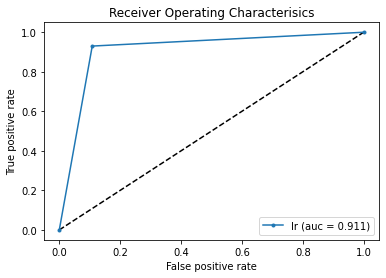

In [ ]:
#AUC
lr_auc_ann_glove = ROC_AUC(y_test, y_pred_ann_glove, f"{Visuals}AUC_ANN_GLOVE")

35/35 [==============================] - 0s 3ms/step - loss: 0.2561 - accuracy: 0.9017
Test Loss:     25.612300634384155 %
Test Accuracy: 90.1728868484497  %
Test error: 9.827113151550293  %


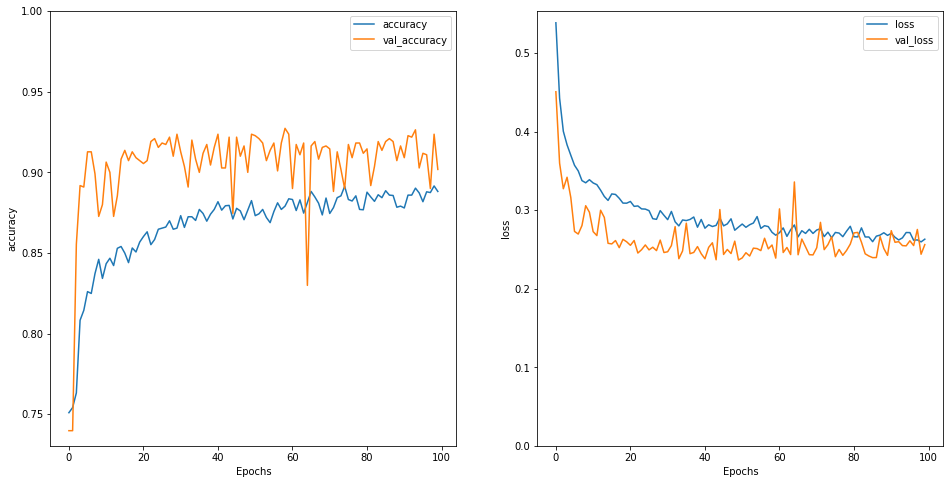

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig(f"{Visuals}ann_glove_accuracy_loss.jpeg")


test_loss_ann_glove, test_acc_ann_glove = ann_glove.evaluate(X_test, y_test)
test_err_ann_glove = 100 - test_acc_ann_glove*100

print(f"Test Loss:     {test_loss_ann_glove*100} %")
print(f"Test Accuracy: {test_acc_ann_glove*100}  %")
print(f"Test error: {test_err_ann_glove}  %")

First sample of the training data set vectorised 
[372267 356798 107050 ...      0      0      0]

First sample of the training data set using index to word : 
university texas conference energy finance february 2001 sherri thanks february vince enron north america corp jeff skilling enron 2000 sent sherri serum enron vince kaminski vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 vince checking date jeff calendar assuming date february holding date whole week trip abroad think flexibility checking back touch soon resolved vince kaminski 2000 jeff skilling corp enron enron vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 jeff friend university texas planning conference energy economics finance february next year would like much keynote speaker given good long term relationship would recommend speak conference talked prof ehud ronn time program think excellent forum present enro

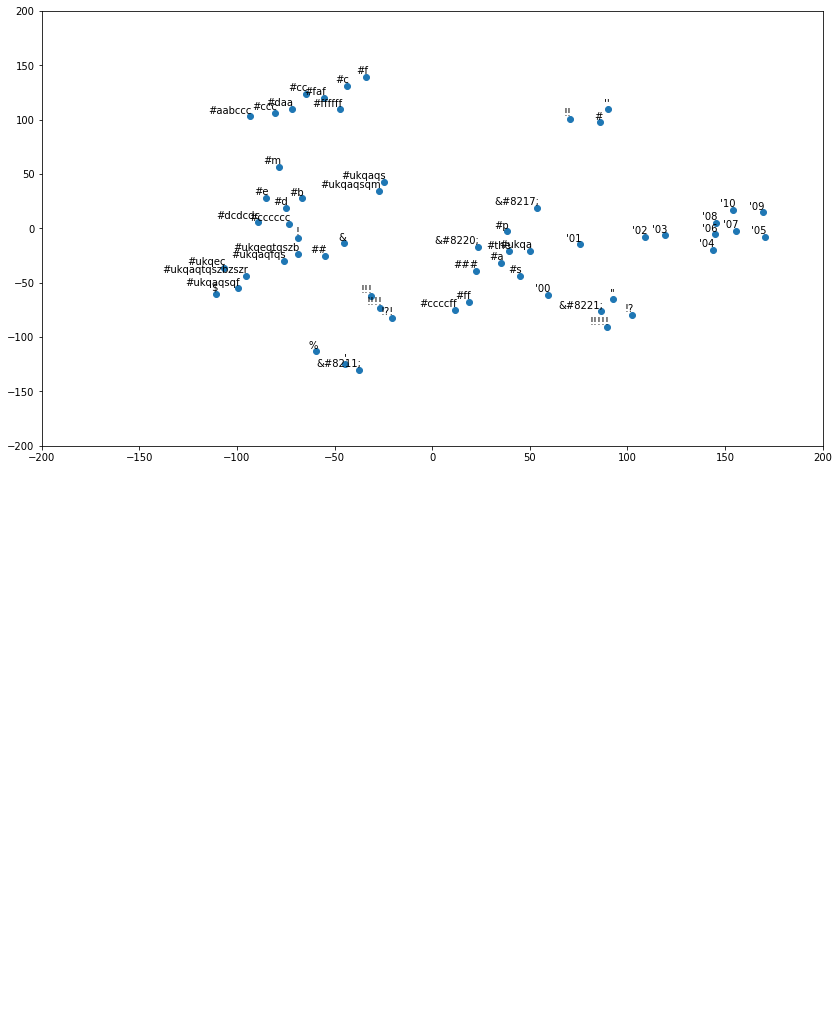

In [ ]:
Word_Embeddings_visualise_TSNE(ann_glove, X_train, index_to_word, f"{Visuals}ann_glove_Embeddings_1", "embedding", -200,200,-200,200, True)

In [ ]:
ann_glove.save(f"{Model}ANN_glove_1.h5")

# **RNN with Glove**

In [ ]:
"""
RNN with glove
"""
rnn_glove = RNN_with_glove((max_length,), word_to_vec_map, word_to_index)
# rnn_glove = RNN_with_glove_architecture_2((max_length,), word_to_vec_map, word_to_index)
rnn_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2400)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 2400, 100)         40000200  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 2400, 256)         234496    
_________________________________________________________________
dropout_4 (Dropout)          (None, 2400, 256)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285

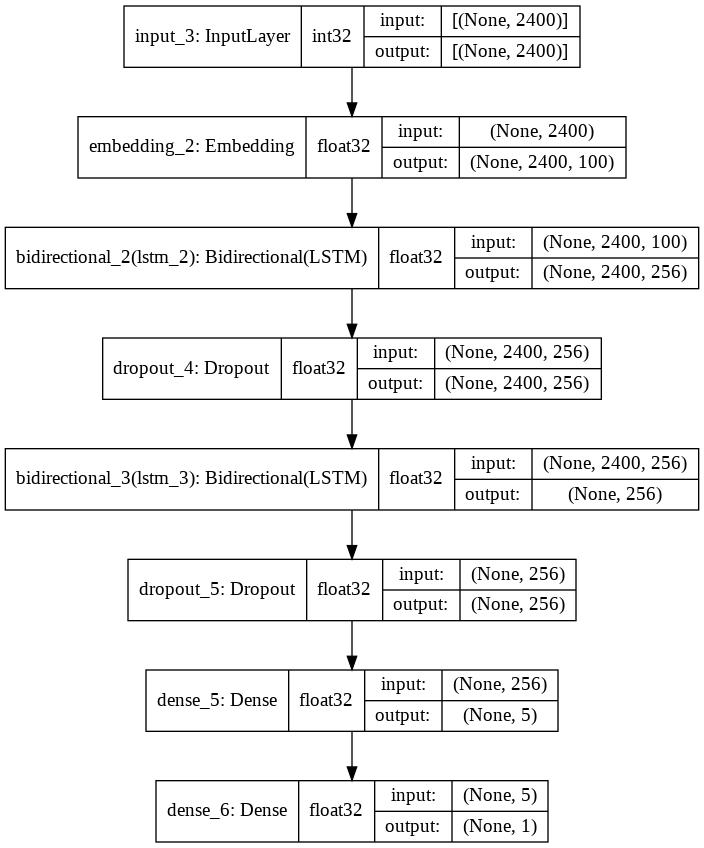

In [ ]:
# display model layers
print(rnn_glove.summary())
plot_model(
    rnn_glove,
    to_file=f"{Visuals}rnn_glove_1.jpeg",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [ ]:
#Information about dtypes of layers of the model
[print(i.shape, i.dtype) for i in rnn_glove.inputs]
print("\n\n")
[print(o.shape, o.dtype) for o in rnn_glove.outputs]
print("\n\n")
[print(l.name, l.input_shape, l.dtype) for l in rnn_glove.layers]

(None, 2400) <dtype: 'int32'>



(None, 1) <dtype: 'float32'>



input_3 [(None, 2400)] int32
embedding_2 (None, 2400) float32
bidirectional_2 (None, 2400, 100) float32
dropout_4 (None, 2400, 256) float32
bidirectional_3 (None, 2400, 256) float32
dropout_5 (None, 256) float32
dense_5 (None, 256) float32
dense_6 (None, 5) float32


[None, None, None, None, None, None, None, None]

In [ ]:
# with tf.device('/device:GPU:0'):
start = perf_counter()
history = rnn_glove.fit(X_train, y_train, epochs = 4, validation_steps = len(X_test), steps_per_epoch= len(X_train), validation_data=(X_test, y_test), verbose=1)
duration_rnn_glove_1 = perf_counter() - start
duration_rnn_glove_1 = round(duration_rnn_glove_1,2)
rnn_history = history

Epoch 1/4
4396/4396 [==============================] - 900s 204ms/step - loss: 0.2394 - accuracy: 0.9029 - val_loss: 0.1339 - val_accuracy: 0.9563
Epoch 2/4
4396/4396 [==============================] - 897s 204ms/step - loss: 0.1037 - accuracy: 0.9591 - val_loss: 0.0810 - val_accuracy: 0.9700
Epoch 3/4
4396/4396 [==============================] - 898s 204ms/step - loss: 0.0923 - accuracy: 0.9704 - val_loss: 0.1001 - val_accuracy: 0.9645
Epoch 4/4
4396/4396 [==============================] - 897s 204ms/step - loss: 0.0614 - accuracy: 0.9752 - val_loss: 0.0713 - val_accuracy: 0.9818


[[802  11]
 [  9 277]]


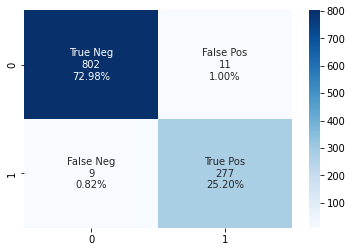

In [ ]:
# Predicting the Test set results
y_pred = rnn_glove.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred_rnn_glove = np.array(y_pred)

#confusion matrix
get_confusion_matrix_heatmap(y_test, y_pred_rnn_glove, f"{heatmaps}RNN_glove")

AUC: 0.9775006666150576


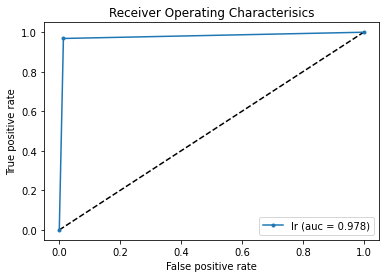

In [ ]:
#AUC
lr_auc_rnn_glove = ROC_AUC(y_test, y_pred_rnn_glove, f"{Visuals}AUC_RNN_GLOVE")

35/35 [==============================] - 6s 156ms/step - loss: 0.0713 - accuracy: 0.9818
Test Loss:     7.127368450164795 %
Test Accuracy: 98.18016290664673  %
Test error: 1.8198370933532715  %


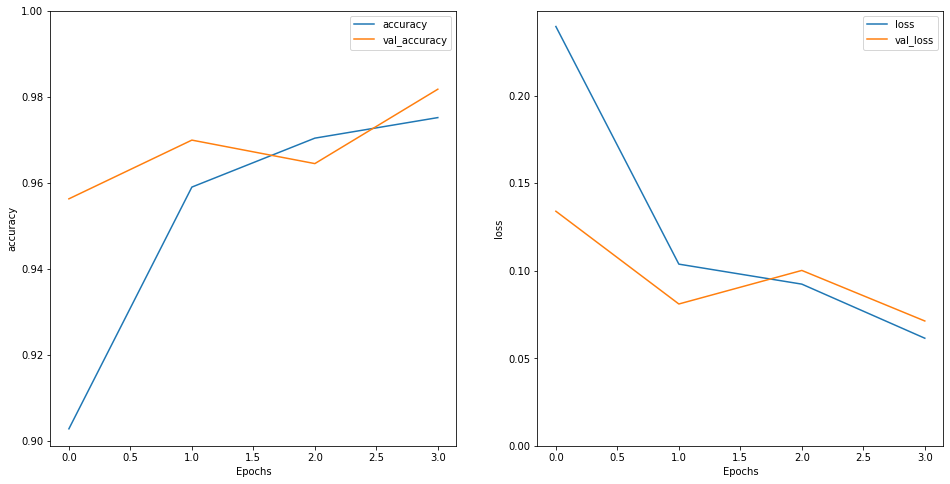

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig(f"{Visuals}rnn_glove_accuracy_loss.jpeg")


test_loss_rnn_glove, test_acc_rnn_glove = rnn_glove.evaluate(X_test, y_test)
test_err_rnn_glove = 100 - test_acc_rnn_glove*100

print(f"Test Loss:     {test_loss_rnn_glove*100} %")
print(f"Test Accuracy: {test_acc_rnn_glove*100}  %")
print(f"Test error: {test_err_rnn_glove}  %")

In [ ]:
Word_Embeddings_visualise_TSNE(rnn_glove, X_train, index_to_word, f"{Visuals}rnn_glove_Embeddings_1", "embedding_1", -200,200,-200,200, True)

First sample of the training data set vectorised 
[372267 356798 107050 ...      0      0      0]

First sample of the training data set using index to word : 
university texas conference energy finance february 2001 sherri thanks february vince enron north america corp jeff skilling enron 2000 sent sherri serum enron vince kaminski vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 vince checking date jeff calendar assuming date february holding date whole week trip abroad think flexibility checking back touch soon resolved vince kaminski 2000 jeff skilling corp enron enron vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 jeff friend university texas planning conference energy economics finance february next year would like much keynote speaker given good long term relationship would recommend speak conference talked prof ehud ronn time program think excellent forum present enro

ValueError: ignored

In [ ]:
rnn_glove.save(f"{Model}RNN_glove_1.h5")

# **CNN with Glove**

In [ ]:
"""
CNN with glove
"""
cnn_glove = CNN_with_glove((max_length,), word_to_vec_map, word_to_index)
# cnn_glove = CNN_with_glove_architecture_2((max_length,), word_to_vec_map, word_to_index)
cnn_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2400)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 2400, 100)         40000200  
_________________________________________________________________
conv1d (Conv1D)              (None, 2398, 20)          6020      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                210 

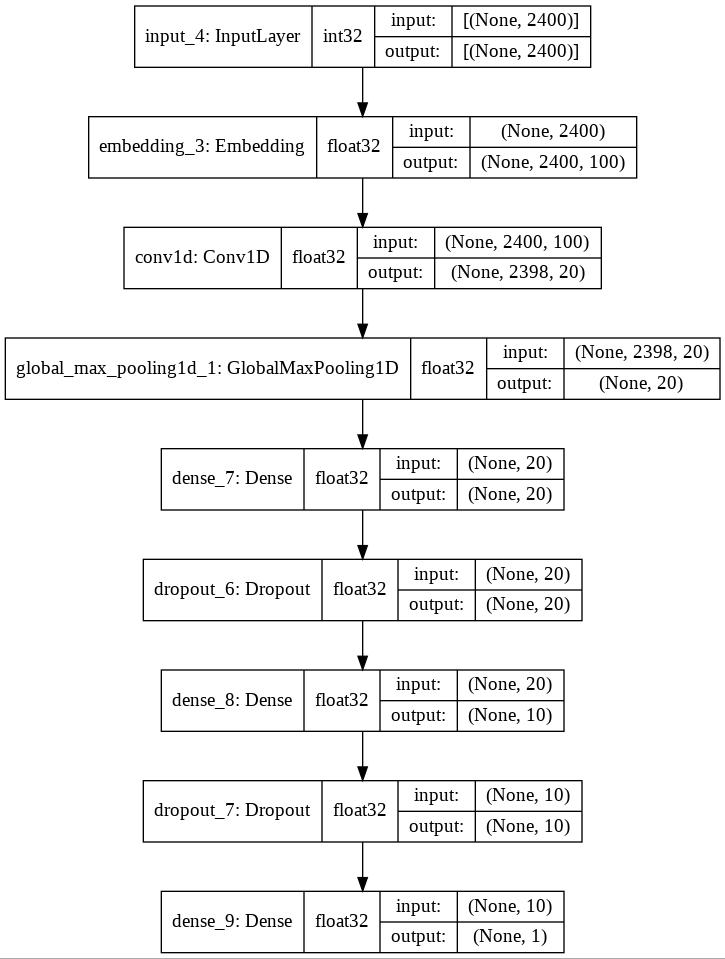

In [ ]:
# display model layers
print(cnn_glove.summary())
plot_model(
    cnn_glove,
    to_file=f"{Visuals}cnn_glove_1.jpeg",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [ ]:
#Information about dtypes of layers of the model
[print(i.shape, i.dtype) for i in cnn_glove.inputs]
print("\n\n")
[print(o.shape, o.dtype) for o in cnn_glove.outputs]
print("\n\n")
[print(l.name, l.input_shape, l.dtype) for l in cnn_glove.layers]

(None, 2400) <dtype: 'int32'>



(None, 1) <dtype: 'float32'>



input_4 [(None, 2400)] int32
embedding_3 (None, 2400) float32
conv1d (None, 2400, 100) float32
global_max_pooling1d_1 (None, 2398, 20) float32
dense_7 (None, 20) float32
dropout_6 (None, 20) float32
dense_8 (None, 20) float32
dropout_7 (None, 10) float32
dense_9 (None, 10) float32


[None, None, None, None, None, None, None, None, None]

In [ ]:
# with tf.device('/device:GPU:0'):
start = perf_counter()
history = cnn_glove.fit(X_train, y_train, epochs = 100, validation_steps = len(X_test), steps_per_epoch= len(X_train), validation_data=(X_test, y_test), verbose=1)
duration_cnn_glove_1 = perf_counter() - start
duration_cnn_glove_1 = round(duration_cnn_glove_1,2)
cnn_history = history

Epoch 1/100
4396/4396 [==============================] - 11s 2ms/step - loss: 0.2192 - accuracy: 0.8995 - val_loss: 0.0760 - val_accuracy: 0.9672
Epoch 2/100
4396/4396 [==============================] - 10s 2ms/step - loss: 0.0660 - accuracy: 0.9779 - val_loss: 0.0739 - val_accuracy: 0.9782
Epoch 3/100
4396/4396 [==============================] - 9s 2ms/step - loss: 0.0393 - accuracy: 0.9854 - val_loss: 0.0770 - val_accuracy: 0.9827
Epoch 4/100
4396/4396 [==============================] - 9s 2ms/step - loss: 0.0377 - accuracy: 0.9882 - val_loss: 0.0922 - val_accuracy: 0.9709
Epoch 5/100
4396/4396 [==============================] - 9s 2ms/step - loss: 0.0245 - accuracy: 0.9916 - val_loss: 0.0675 - val_accuracy: 0.9800
Epoch 6/100
4396/4396 [==============================] - 9s 2ms/step - loss: 0.0159 - accuracy: 0.9957 - val_loss: 0.0714 - val_accuracy: 0.9827
Epoch 7/100
4396/4396 [==============================] - 10s 2ms/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.1259 - val

[[803  10]
 [  8 278]]


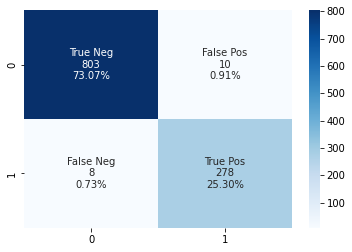

In [ ]:
# Predicting the Test set results
y_pred = cnn_glove.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred_cnn_glove = np.array(y_pred)

#confusion matrix
get_confusion_matrix_heatmap(y_test, y_pred_cnn_glove, f"{heatmaps}CNN_glove")

AUC: 0.979863924513371


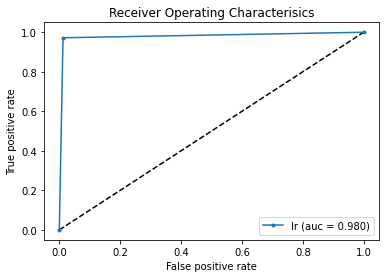

In [ ]:
#AUC
lr_auc_cnn_glove = ROC_AUC(y_test, y_pred_cnn_glove, f"{Visuals}AUC_CNN_GLOVE")

35/35 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.9836
Test Loss:     69.12458539009094 %
Test Accuracy: 98.36214780807495  %
Test error: 1.6378521919250488  %


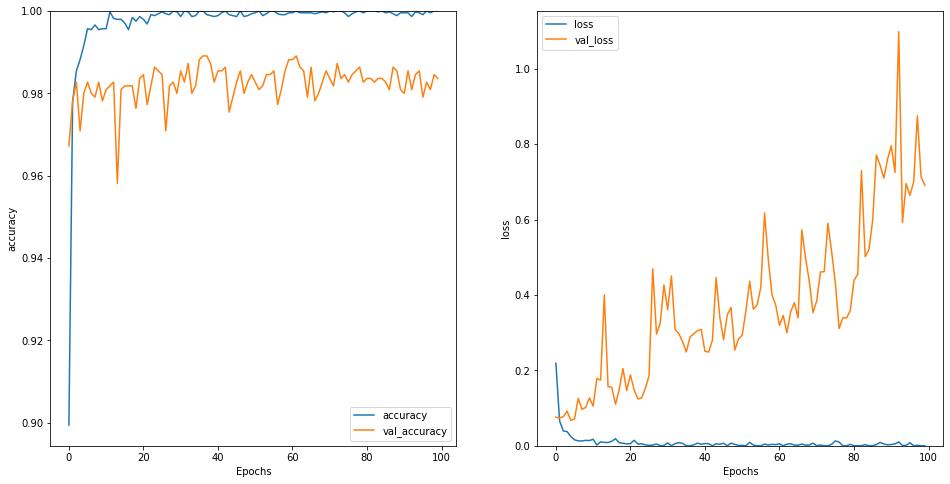

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig(f"{Visuals}cnn_glove_accuracy_loss.jpeg")


test_loss_cnn_glove, test_acc_cnn_glove = cnn_glove.evaluate(X_test, y_test)
test_err_cnn_glove = 100 - test_acc_cnn_glove*100

print(f"Test Loss:     {test_loss_cnn_glove*100} %")
print(f"Test Accuracy: {test_acc_cnn_glove*100}  %")
print(f"Test error: {test_err_cnn_glove}  %")

In [ ]:
Word_Embeddings_visualise_TSNE(cnn_glove, X_train, index_to_word, f"{Visuals}cnn_glove_Embeddings_1", "embedding_2", -200,200,-200,200, True)

First sample of the training data set vectorised 
[372267 356798 107050 ...      0      0      0]

First sample of the training data set using index to word : 
university texas conference energy finance february 2001 sherri thanks february vince enron north america corp jeff skilling enron 2000 sent sherri serum enron vince kaminski vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 vince checking date jeff calendar assuming date february holding date whole week trip abroad think flexibility checking back touch soon resolved vince kaminski 2000 jeff skilling corp enron enron vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 jeff friend university texas planning conference energy economics finance february next year would like much keynote speaker given good long term relationship would recommend speak conference talked prof ehud ronn time program think excellent forum present enro

ValueError: ignored

In [ ]:
cnn_glove.save(f"{Model}CNN_glove_1.h5")

# **Evaluation Metrics Comparison**

In [ ]:
"""
Model comparison table with metrics : 
1. Accuracy
2. Loss
3. Error
4. Precision, Recall, F1 score
5. ROC AUC
"""
ann_acc_t = ann_history.history["accuracy"][len(ann_history.history["accuracy"])-1]
rnn_acc_t = rnn_history.history["accuracy"][len(rnn_history.history["accuracy"])-1]
cnn_acc_t = cnn_history.history["accuracy"][len(cnn_history.history["accuracy"])-1]
Model_comparison = {
    "Ann with GLOVE embeddings": 
    {"model":ann_glove, "Train_acc":ann_acc_t, "acc":0, "loss" : 0, "err":0, "lr_auc":0, "f1_score":0, "precision":0, "recall":0, "y_pred":0, "duration":duration_ann_glove_1 },
    "Rnn with GLOVE embeddings": 
    {"model":rnn_glove, "Train_acc":rnn_acc_t, "acc":0, "loss" : 0, "err":0, "lr_auc":0, "f1_score":0, "precision":0, "recall":0, "y_pred":0, "duration":duration_rnn_glove_1},
    "Cnn with GLOVE embeddings": 
    {"model":cnn_glove, "Train_acc":cnn_acc_t, "acc":0, "loss" : 0, "err":0, "lr_auc":0, "f1_score":0, "precision":0, "recall":0, "y_pred":0, "duration":duration_cnn_glove_1}
}

for name, model in Model_comparison.items():

  if name == "Ann with GLOVE embeddings":
    model["y_pred"]= y_pred_ann_glove
  if name == "Rnn with GLOVE embeddings":
    model["y_pred"]=y_pred_rnn_glove
  if name == "Cnn with GLOVE embeddings":
    model["y_pred"]=y_pred_cnn_glove

for name, model in Model_comparison.items():
    y_pred = model["y_pred"]
    y_pred = np.asarray(y_pred)
    precision, recall, f1_score_, accuracy, lr_auc = get_Metrics(y_test, y_pred)
      
    if name == "Ann with GLOVE embeddings":
      model["acc"]=test_acc_ann_glove
      model["loss"]=test_loss_ann_glove
      model["err"]=test_err_ann_glove
      model["lr_auc"]=lr_auc_ann_glove
      model["f1_score"]=precision
      model["precision"]=recall
      model["recall"]=f1_score_
      
    if name == "Rnn with GLOVE embeddings":
      model["acc"]=test_acc_rnn_glove
      model["loss"]=test_loss_rnn_glove
      model["err"]=test_err_rnn_glove
      model["lr_auc"]=lr_auc_rnn_glove
      model["f1_score"]=precision
      model["precision"]=recall
      model["recall"]=f1_score_
     
    if name == "Cnn with GLOVE embeddings":
      model["acc"]=test_acc_cnn_glove
      model["loss"]=test_loss_cnn_glove
      model["err"]=test_err_cnn_glove
      model["lr_auc"]=lr_auc_cnn_glove
      model["f1_score"]=precision
      model["precision"]=recall
      model["recall"]=f1_score_
    # print(model)

models_metrics = []
for name, model in Model_comparison.items():
  #print(model["y_pred"].shape)
  precision, recall, f1_score_,  = model["precision"], model["recall"], model["f1_score"]
  accuracy, lr_auc, loss, error = model["acc"], model["lr_auc"], model["loss"], model["err"]
  Train_acc, duration = model["Train_acc"], model["duration"]
  # print(f"precision : {precision} recall : {recall} f1_score : {f1_score_} accuracy : {accuracy}")
  models_metrics.append([name, precision, recall, f1_score_, Train_acc, accuracy, error, loss, lr_auc, duration])

df_metrics = pd.DataFrame(models_metrics)
df_metrics.columns = ['Model', 'Precision', 'Recall', 'f1 score', "Train Accuracy", 'Test Accuracy', 'Error', 'Loss', 'ROC-AUC', "Train Time (s)"]
df_metrics.sort_values(by = 'Test Accuracy', ascending = False, inplace=True)
df_metrics.reset_index(drop = True, inplace=True)
df_metrics.to_csv(f"{Visuals}DNN_glove_1_comparison.csv")
    

In [ ]:
df_metrics

,Model,Precision,Recall,f1 score,Train Accuracy,Test Accuracy,Error,Loss,ROC-AUC,Train Time (s)
0,Cnn with GLOVE embeddings,0.979864,0.978779,0.977707,1.000000,0.983621,1.637852,0.691246,0.979864,942.53
1,Rnn with GLOVE embeddings,0.977501,0.976421,0.975354,0.975205,0.981802,1.819837,0.071274,0.977501,3592.29
2,Ann with GLOVE embeddings,0.910914,0.880965,0.862283,0.888080,0.901729,9.827113,0.256123,0.910914,806.91
